### Perturbed Harper model and associated quantum system 
goal of this notebook is to show Husimi functions in the separatrix region as a function of N

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from scipy.integrate import odeint
import mpmath as mpmath

# %matplotlib notebook 
%matplotlib inline 

In [4]:
# routines for displacement operator, coherent states and Husimi distribution 

# return Xhat as a 2d NxN complex matrix (unitary)   
def Xhat_op(N): # in regular basis 
    X = np.zeros((N,N),dtype=complex)
    for k in range(N):
        X[(k+1)%N,k] = 1.0 + 0j
    return X

# return Zhat as a 2d NxN complex matrix (unitary)  
def Zhat_op(N):  # in regular basis
    Z = np.zeros((N,N),dtype=complex)
    for k in range(N):
        omegaj = np.exp(2*np.pi*k*1j/N)
        Z[k,k] = omegaj 
    return Z

# adjoint of Zhat
def Zhat_dagger_op(N):
    return np.conjugate(Zhat_op(N))

# adjoint of Xhat
def Xhat_dagger_op(N):
    return np.transpose(Xhat_op(N))

# additional discrete ops
def cos_phi_op(N):
    return (Zhat_op(N) + Zhat_dagger_op(N))*0.5

def sin_phi_op(N):
    return (Zhat_op(N) - Zhat_dagger_op(N))/(2.0j)

def cos_p_op(N):
    return (Xhat_op(N) + Xhat_dagger_op(N))*0.5

def sin_p_op(N):
    return (Xhat_op(N) - Xhat_dagger_op(N))/(2.0j)

# create Dhat, the displacement operator as a function of k,l  
# returns an NxN complex matrix, is unitary 
# computes omega^-kl/2  X^l Z^k
def Displacement_op(N,k,l):
    #D = np.zeros((N,N),dtype=complex)
    omega = np.exp(2*np.pi*1j/N)
    #omfac = np.power(-omega*k*l/2.0)
    X = Xhat_op(N)
    Z = Zhat_op(N)
    Xl = np.linalg.matrix_power(X, l)
    Zk = np.linalg.matrix_power(Z, k)
    Dhat= np.power(omega,-k*l/2.0) * np.matmul(Zk,Xl)
    return Dhat

# computes eigenfunction |\tilde eta> of the QFT 
# returns an N dimensional complex normalized statevector 
# This is a unimodal periodic thing which is peaked at index 0
def eta_tilde(N):
    eta = np.zeros(N,dtype=complex)
    efac = np.exp(-np.pi/N)
    for m in range(N):  # compute using theta function 
        eta[m] = np.real(mpmath.jtheta(3,np.pi*m/N,efac)/np.sqrt(N))
    eta_mag = np.sqrt(np.sum(eta*np.conj(eta)))
    eta = eta/eta_mag   # normalize
    return eta

#  Creat a coherent state from Displacement operator hat D and eigenfunction |tilde eta>
# returns an N dimensional complex normalized state vector 
def coherent_state(N,k,l):
    Dhat = Displacement_op(N,k,l)
    eta=eta_tilde(N)
    ch = np.matmul(Dhat,eta)
    return ch

# make a set of coherent states from QFT eigenfunction |tilde eta> and displacement op
# returns an N x N x N 3D complex array 
#   the matrix [k,l,:] is the coherent state |k,l>
#  a more efficient version 
def coh_Dkl_b(N):
    c_matrix = np.zeros((N,N,N),dtype=complex)
    eta=eta_tilde(N)  #only do this once
    omega = np.exp(2*np.pi*1j/N)  #only do this once
    #omfac = np.power(-omega*k*l/2.0)
    X = Xhat_op(N) # only do this once
    Z = Zhat_op(N) # only do this once
    Zk = np.linalg.matrix_power(Z, 0)
    for k in range(N):
        Xl = np.linalg.matrix_power(X, 0)
        for l in range(N):
            #Xl = np.linalg.matrix_power(X, l)
            Dhat = np.power(omega,-k*l/2.0) * np.matmul(Zk,Xl)
            #Dhat = Displacement_op(N,k,l)
            c_matrix[k,l,:] = np.matmul(Dhat,eta)  
            # if displacement is in p direction then p increases with l
            # and k increases in x direction 
            # note that imshow displays arrays with [j,k] with j in y direction
            Xl = np.matmul(X,Xl)
        Zk = np.matmul(Z,Zk)
    return c_matrix
   
# compute Hussimi distribution of an N dimensional state vector psi 
# in advance you have computed a set of coherent states with above
#    routine coh_Dkl_b(N) 
# the set of coherent states is given via the argument c_matrix 
#    c_matrix should be an NxNxN matrix 
# the routine returns an NxN real matrix which is the Hussimi function  
#   note that index order is p,x  so that y would be first index, as expected for plotting with imshow
def Husimi(psi,c_matrix):
    N = len(psi)
    H_matrix = np.zeros((N,N))
    cshape = c_matrix.shape
    if (cshape[0] != N):
        print('c_matrix is wrong dimension')
    for k in range(N):
        for l in range(N):
            co_kl = np.squeeze(c_matrix[k,l,:])  #coherent state |k,l> -p,x
            mag = np.vdot(psi,co_kl) # dot product
            mag = np.absolute(mag) # is real 
            H_matrix[k,l] = mag**2  

    return H_matrix

In [5]:
# routines for showing eigenvalues of a unitary operator 
# also for computing the QFT and its inverse  

# arguments: w an array of complex eigenvalues, assumed roots of unity
# sorts the phases
# returns: an array of normalized differences between the phases of the eigenvalues 
twopi = np.pi*2
def compute_s(w):
    phi_arr = np.angle(w) # get the phase angles in [-pi,pi] of complex numbers
    # this ignores magnitude of w if it is not on the unit circle 
    phi_arr_sort = np.sort(phi_arr)  # put in order of increasing phase
    phi_shift = np.roll(np.copy(phi_arr_sort),1)
    dphi = (phi_arr_sort - phi_shift + np.pi)%twopi - np.pi  # takes care of 2pi shift
    mu_dphi = np.mean(dphi)  # find mean value of dphi 
    sarr = dphi/mu_dphi  # this is s /<s>
    return sarr  # returns normalized phase differences 

# sort eigenvalues and eigenvectors in order of increasing phase
# eigenvectors from np.linalg.eig are in form vr[:,j]
def esort_phase(w,vr):
    phi_arr = np.angle(w) # get the phase angles in [-pi,pi] of complex numbers
    iphi = np.argsort(phi_arr) # in order of increasing phase
    wsort = w[iphi]
    vrsort = np.copy(vr)*0.0
    for i in range(len(w)):
        vrsort[:,i] = vr[:,iphi[i]]
    #vrsort = vr[:,iphi]  # does this work? I think so! yes
    return wsort,vrsort

# create a probability vector for the i-th eigenvector 
# vr is an array of eigenvectors 
def get_probs(vr,i):
    v = vr[:,i]
    probi = np.real(v*np.conjugate(v)) # probability vector 
    return probi  # should be n dimensional real vector 

# fill matrices with Discrete Fourier transform, returns 2 nxn matrices
# both Q_FT and Q_FT^dagger which is the inverse 
def QFT(n):
    omega = np.exp(2*np.pi*1j/n)
    Q        = np.zeros((n,n),dtype=complex)  # QFT
    Q_dagger = np.zeros((n,n),dtype=complex) 
    for j in range(n):
        for k in range(n):
            Q[j,k] = np.power(omega,j*k)  # not 100% sure about sign here! 
            Q_dagger[j,k] = np.power(omega,-j*k)
    Q        /= np.sqrt(n)  #normalize
    Q_dagger /= np.sqrt(n)
    return Q,Q_dagger 



In [10]:
# compute the expectation value of operator, using a state vector evec 
def exp_val(evec,op):
    zvec = np.matmul(op,evec)   # compute op|evec>
    w = np.vdot(evec,zvec)   # complex dot product, evec is conjugated prior to doing the dot product 
    return w 

# sort a set of eigenvalues and eigenfunctions according to the expectation value of an operator 
# returns expectation values and dispersions 
def esort_op(w,vr,op):
    n = len(w)
    exp_arr = np.zeros(n,dtype=complex) # to store the expectation values  <op>
    sig_arr = np.zeros(n,dtype=complex) # to store <op^2> - <op>^2
    for i in range(n):
        mu =  exp_val(np.squeeze(vr[:,i]), op)  #h
        mu2 = exp_val(np.squeeze(vr[:,i]), np.matmul(op,op)) #h^2
        sig2 = mu2-mu*mu # compute dispersion too 
        exp_arr[i] = mu
        sig_arr[i] = sig2  # notice is dispersion not std
        # compute the expectation values of the operator for every eigenfunction 
    iphi = np.argsort(np.real(exp_arr)) # sort in order of increasing expectation value 
    wsort = w[iphi]  # sort the eigenvalues 
    expsort = exp_arr[iphi] # sort the expectation values 
    sigsort = sig_arr[iphi] # sort the dispersions 
    vrsort = np.copy(vr)*0.0 # to store the eigenfunctions in order of expectation vals
    for i in range(len(w)):
        vrsort[:,i] = vr[:,iphi[i]]  # sort the eigenfunctions which are vr[:,j]

    return wsort,vrsort,expsort,sigsort

# $\hat h_0 = a(1 - cos \hat p) - \epsilon \cos \hat \phi$
# computes the operator hat h_0, unperturbed hamiltonian 
# much better routine 
def hat_h_0_new(N,a,eps):
    return a*(np.identity(N) - cos_p_op(N)) - eps*cos_phi_op(N)


# get and return eigenvalues and eigenvecs of unperturbed hamiltonian h0 but in order of increasing eigenvalue
# calls routine hat_h_0_new()
def eigs_h0(n,a,eps):
    H0op = hat_h_0_new(n,a,eps) # store unperturbed hamiltonian op hat h_0
    (w,vr)=np.linalg.eig(H0op)  # get eigenvalues and eigenvectors
    iphi = np.argsort(np.real(w)) # in order of increasing energy
    wsort = np.real(w[iphi])
    vrsort = np.copy(vr)*0.0
    for i in range(len(w)):
        vrsort[:,i] = vr[:,iphi[i]]  # sort eigenvectors 
    return wsort,vrsort

In [6]:

# compute the propagator U across tau =0 to  2 pi
# trying a somewhat more efficient way to do this!
#  arguments:
#     N      : size of discrete quantum space 
#     ntau   : how many Trotterized steps to take 
#     a,b,eps,mu,mup,taushift      : parameters of classical model, all unitless 
#  returns:  
#    Ufinal  : The propagator hat U_T  (NxN complex matrix)
#    w       : vector of eigenvalues of U in order of increasing phase
#    vr      : vector of associated eigenfunctions of U 
#        vr[:,j] is the eigenvector with eigenvalue w[j]
# note we have shifted indexing so that phi=0, p=0 is in the center of the 2d arrays
def U_prop2(N,ntau,a,b,eps,mu,mup,taushift):
    DLambda_A =np.zeros((N,N),dtype=complex)  # storing diagonal matrix for momentum part
    DLambda_Ah =np.zeros((N,N),dtype=complex)  # storing diagonal matrix for momentum part
    DLambda_Ahm =np.zeros((N,N),dtype=complex)  # storing diagonal matrix for momentum part
    DLambda_B =np.zeros((N,N),dtype=complex)  # storing diagonal matrix for phi part
    U_final  =np.zeros((N,N),dtype=complex)  # final propagator
    #Efac = N**2/(4.0*np.pi*ntau)    # includes dtau , is wrong
    Efac = N/ntau    # Bohr Sommerfeld type quantization gives this
    # this is L_0/hbar x 2pi/ntau = N/2pi x 2pi/ntau = N/ntau, is correct , includes dtau
    
    dtau = 2*np.pi/ntau  # step size 
    Q_FT,Q_FT_dagger = QFT(N)  # need only be computed once
    for k in range(N):  #compute ahead of time, fill diagonals
        pk = 2*np.pi*k/N - np.pi  # shifted so 0,0 in center of arrays
        DLambda_Ah[k,k] = np.exp(-0.5j*Efac*a*(1.0 - np.cos(pk-b))) #diagonal in Fourier basis
        DLambda_A[k,k]  = np.exp(  -1j*Efac*a*(1.0 - np.cos(pk-b))) 
        DLambda_Ahm[k,k]= np.exp( 0.5j*Efac*a*(1.0 - np.cos(pk-b))) 
        # these are half step and full step for the momentum part
        
    LAh     = np.matmul(Q_FT,np.matmul(DLambda_Ah ,Q_FT_dagger))  # transfer basis 
    LA      = np.matmul(Q_FT,np.matmul(DLambda_A  ,Q_FT_dagger))   
    LAh_inv = np.matmul(Q_FT,np.matmul(DLambda_Ahm,Q_FT_dagger))
    
    U_final = LAh;  #inverse half step at the beginning 
        
    for i in range(ntau): # each dtau
        tau = i*dtau + taushift # time of propagator shifted by taushift
        for j in range(N):
            phi = 2*np.pi*j/N - np.pi  # shifted so 0,0 in center of arrays 
            DLambda_B[j,j] = np.exp(1j*Efac*(\
                eps*np.cos(phi)+mu*np.cos(phi-tau)+mup*np.cos(phi+tau) )) # create diagonal matrix 
            # note sign of 1j 
        U_final = np.matmul(LA,np.matmul(DLambda_B,U_final))
        
    U_final = np.matmul(LAh_inv,U_final)
    
    (w,vr)=np.linalg.eig(U_final)  # get eigenvalues and eigenvectors
    w_s,vr_s = esort_phase(w,vr)   # sort in order of increasing eigenvalue phase
    return w_s,vr_s,U_final 
            
            

In [8]:
# compute coherent states 
c_matrix_16 = coh_Dkl_b(16)  # 
c_matrix_32 = coh_Dkl_b(32)  # 
#c_matrix_65 = coh_Dkl_b(65)  # 
#c_matrix_127 = coh_Dkl_b(127)  # 

In [31]:
c_matrix_64 = coh_Dkl_b(64)  # 
c_matrix_128 = coh_Dkl_b(128)  # 

In [9]:
#c_matrix_255 = coh_Dkl_b(255)  # takes a while

In [34]:
c_matrix_256 = coh_Dkl_b(256)  # takes a while

In [45]:
# return eigenstates of propagator with energies near those of the separatrices 
def sep_states(n,a,eps,mu,mup,ks,c_matrix):
    b=0;  taushift=0
    ntau = 4*n
    w,vr,Up= U_prop2(n,ntau,a,b,eps,mu,mup,taushift) # compute propagator, 
    # energies and eigenvectors are sorted according in order of phase 
    h0 = hat_h_0_new(n,a,eps)  # compute unperturbed hamiltonian op hat h_0
    wsort2,vrsort2,expsort,sigsort = esort_op(w,vr,h0)  # sort eigenvecs in order of expectation of H0 
    # compute energies of separatrices 
    sep_E1 = eps
    sep_E2 = 2*a - eps
    ii1 = np.argmin(np.abs(expsort - sep_E1))  # find index of states with energies nearest those of separatrix 
    ii2 = np.argmin(np.abs(expsort - sep_E2))
    vr1 = np.squeeze(vrsort2[:,ii1+ks]) # these are the eigenvectors with energies closest to separatrix 
    vr2 = np.squeeze(vrsort2[:,ii2+ks])
    print(ii1,ii2)
    H1 = Husimi(vr1,c_matrix)
    H2 = Husimi(vr2,c_matrix)
    return H1, H2  # return Husimi functions 

# return eigenstates of propagator with energies near those of the separatrices 
def sep_states_simp(n,a,mu,mup,ks,c_matrix):
    b=0;  taushift=0; eps = a;
    ntau = 4*n
    w,vr,Up= U_prop2(n,ntau,a,b,eps,mu,mup,taushift) # compute propagator, 
    # energies and eigenvectors are sorted according in order of phase 
    h0 = hat_h_0_new(n,a,eps)  # compute unperturbed hamiltonian op hat h_0
    wsort2,vrsort2,expsort,sigsort = esort_op(w,vr,h0)  # sort eigenvecs in order of expectation of H0 
    # compute energies of separatrices 
    #sep_E1 = eps
    #sep_E2 = 2*a - eps
    #ii1 = np.argmin(np.abs(expsort - sep_E1))  # find index of states with energies nearest those of separatrix 
    #ii2 = np.argmin(np.abs(expsort - sep_E2))
    ii = int(n/2)
    vvr = np.squeeze(vrsort2[:,ii+ks]) # these are the eigenvectors with energies closest to separatrix 
    print(ii)
    H1 = Husimi(vvr,c_matrix)
    return H1 # return Husimi function 




In [49]:
a = 1.5; eps = a;  mu=0.1;mup=0; ks=0
H1_16,H2_16 = sep_states(16,a,eps,mu,mup,ks,c_matrix_16)
H1_32,H2_32 = sep_states(32,a,eps,mu,mup,ks,c_matrix_32)
H1_64,H2_64 = sep_states(64,a,eps,mu,mup,ks,c_matrix_64)
#H1_65,H2_65 = sep_states(65,a,eps,mu,c_matrix_65)
#H1_127,H2_127 = sep_states(127,a,eps,mu,c_matrix_127)
H1_128,H2_128 = sep_states(128,a,eps,mu,mup,ks,c_matrix_128)
#H1_255,H2_255 = sep_states(255,a,eps,mu,c_matrix_255)
H1_256,H2_256 = sep_states(256,a,eps,mu,mup,ks,c_matrix_256)

8 8
16 16
31 31
63 63
128 128


In [68]:
a = 1.5;  mu=0.15;mup=0; ks=0
Ha_16 = sep_states_simp(16,a,mu,mup,ks,c_matrix_16)
Ha_32 = sep_states_simp(32,a,mu,mup,ks,c_matrix_32)
Ha_64= sep_states_simp(64,a,mu,mup,ks,c_matrix_64)
Ha_128 = sep_states_simp(128,a,mu,mup,ks,c_matrix_128)
Ha_256 = sep_states_simp(256,a,mu,mup,ks,c_matrix_256)

8
16
32
64
128


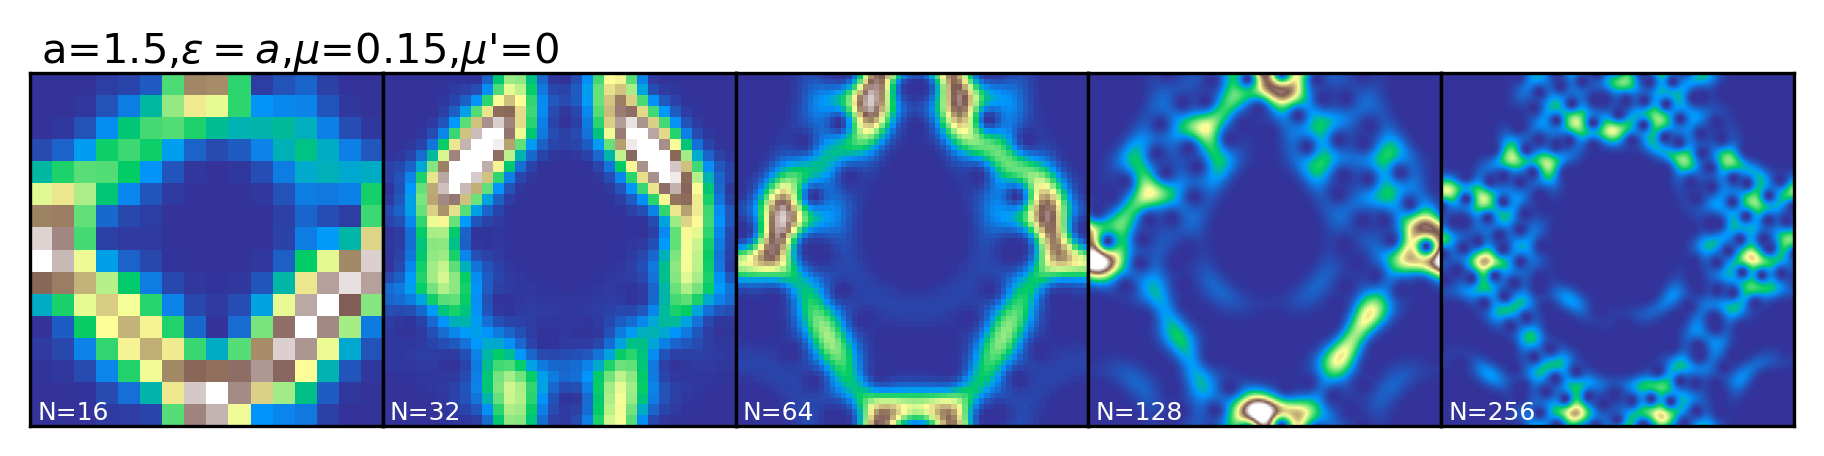

In [78]:
nw=5
fig, axarr = plt.subplots(1,nw,figsize=(6,1.5),dpi=300)
plt.subplots_adjust(hspace=0,wspace=0,bottom=0.01,top=0.97,right=0.99,left=0.01)
for k in range(nw):
    axarr[k].set_xticks([])
    axarr[k].set_yticks([])
im=axarr[0].imshow(Ha_16,origin='lower',vmin=0,\
        vmax=1.0/np.sqrt(16),cmap='terrain') # flips y direction of display
im=axarr[1].imshow(Ha_32,origin='lower',vmin=0,\
        vmax=1.0/np.sqrt(32),cmap='terrain') 
im=axarr[2].imshow(Ha_64,origin='lower',vmin=0,\
        vmax=1.0/np.sqrt(64),cmap='terrain') 
im=axarr[3].imshow(Ha_128,origin='lower',vmin=0,\
        vmax=1.0/np.sqrt(128),cmap='terrain') 
im=axarr[4].imshow(Ha_256,origin='lower',vmin=0,\
        vmax=1.0/np.sqrt(256),cmap='terrain') 

xi = 0.02;yi=0.02; fc=6
axarr[0].text(xi,yi,'N=16',color='white',fontsize=fc,transform=axarr[0].transAxes)
axarr[1].text(xi,yi,'N=32',color='white',fontsize=fc,transform=axarr[1].transAxes)
axarr[2].text(xi,yi,'N=64',color='white',fontsize=fc,transform=axarr[2].transAxes)
axarr[3].text(xi,yi,'N=128',color='white',fontsize=fc,transform=axarr[3].transAxes)
axarr[4].text(xi,yi,'N=256',color='white',fontsize=fc,transform=axarr[4].transAxes)

clabel = r'a={:.1f},$\epsilon=a$,$\mu$={:.2f},'.format(a,mu);
muprime = r'$\mu$' + '\'' + '=0'
clabel+=muprime
axarr[0].text(0,16.0,clabel)
plt.savefig('ergo.png')
plt.show() 

In [9]:
# compute and store Husimi distributions for all eigenfunctions in an nxnxn array
# arguments:
#    vr eigenvectors  (nxn) matrix but eigenvectors are [:,j]
#    c_matrix nxn matrix of coherent states, precomputed with Dkl_b(n)
# returns matrix of Husimi distributions
def stor_Hus(vr,c_matrix):
    vshape = vr.shape; cshape = c_matrix.shape
    n =vshape[0] 
    if (cshape[0]  != n):
        print('c_matrix wrong size')
        return 0
    Hmatrix_big = np.zeros((n,n,n))  # allocate memory
    for k in range(n):   # loop over eigenstates 
        Hmatrix_big[:,:,k]= Husimi(np.squeeze(vr[:,k]),c_matrix)
    return Hmatrix_big

# show Husimi functions for all eigenfunctions
# arguments:
#  Hmatrix_big: matrix of husimi functions, precomputed
import matplotlib.ticker as mticker
def show_Hus(Hmatrix_big,froot,pcolorbar):
    if (hasattr(Hmatrix_big, "__len__") == False):
        exit
    hshape = Hmatrix_big.shape;
    n =hshape[0]
    sn = int(np.sqrt(n))
    if (n - sn*sn>0):
        sn+=1;   #increase number of square so that all states are displayed

    fig,axarr = plt.subplots(sn,sn,figsize=(5.1,5.0),sharex=True,sharey=True,dpi=200)
    plt.subplots_adjust(hspace=0,wspace=0,left=0.08,right=1.0,top=0.95,bottom=0.0);
    axarr[0,0].set_xticks([])
    axarr[0,0].set_yticks([])
    zmax = 1/sn  # could be adjusted!!!! or an argument
    
    ax=fig.add_axes([0,0,1,1],frame_on = False) 
    ax.set_xticks([])
    ax.set_yticks([])
    if (n < 200):
        ax.text(0.00,0.94,'b)',transform=ax.transAxes,fontsize=26)
    
    for i in range(sn):
        for j in range(sn): 
            axarr[i,j].set_aspect('equal')
    
    for i in range(sn):   # plots are in y direction from top to down
        for j in range(sn):  # plots in x direction from left to right
            k = i*sn + j  # incrementing horizontally first
            if (k < n):
                Hmatrix = np.squeeze(Hmatrix_big[:,:,k])
                im=axarr[i,j].imshow(Hmatrix,origin='lower',vmin=0,\
                                     vmax=zmax,cmap='terrain') # flips y direction of display
                #im=axarr[i,j].imshow(Hmatrix,vmin=0,vmax=zmax,cmap='terrain')
                if (k==0):
                    im0 = im
    
    if (pcolorbar==True):
        cax=fig.add_axes([0.055,0.03,0.02,0.5])
        cbar = plt.colorbar(im0,cax=cax,ticks = [0,zmax],location='left',format=mticker.FixedFormatter(['0', '']))        #ticklabs = cbar.ax.get_yticklabels()
        #cbar.ax.set_yticklabels([ticklabs[0]], fontsize=8)
        #print(ticklabs)
        ccc = '{:.3e}'.format(zmax)
        cax.text(0.5,zmax*1.02,ccc,fontsize=8,rotation='vertical',va='bottom',ha='center')
        #cbar.ax.major_ticklabels.set_pad(-3) v1 = np.linspace(Z.min(), Z.max(), 8, endpoint=True)
        #cbar=plt.colorbar(ticks=v1)              # the mystery step ???????????
        #cbar.ax.set_yticklabels(["{:4.2f}".format(i) for i in v1]) # add the labels
    
    if (len(froot)>2):
        
        ofile = froot + '_Hus.png'
        plt.savefig(ofile,dpi=200)
    plt.show()   


#sim2v.Hus(True) # show husimi function of eigenvecs 
#sim4.Hus(True) # show husimi function of eigenvecs 

In [10]:
# class structure to store a specific dynamical system 
# requires c_matrix, storing coherent states to be made ahead of time
class Hsys:
    def __init__(self,n,ntau,a,b,eps,mu,mup,taushift,c_matrix,froot):
        self.n = n
        self.ntau = ntau
        self.a = a
        self.b = b
        self.eps = eps
        self.mu = mu
        self.mup = mup
        self.taushift = taushift
        self.froot = froot
        norb  = 100; npoints =200
        self.cla = Hcla(norb,npoints,a,b,eps,mu,mup,taushift,froot) # make a classical class 
        # compute the propagator and eigenfunctions and eigenvalues
        w,vr,Up= U_prop2(n,ntau,a,b,eps,mu,mup,taushift) # is sorted according in order of phase 
        self.w = w   # quasi-eigenvalues  (order of phase)
        self.vr = vr  # eigenvectors (order of phase)
        self.Up = Up   # unitary transformation 
        self.c_matrix = c_matrix   # matrix of coherent states
        # compute Husimi distribution
        #self.Hmatrix_big = stor_Hus(self.vr,self.c_matrix)
        # compute the operator hat h_0
        self.H0 = hat_h_0_new(self.n,self.a,self.eps)  # store unperturbed hamiltonian op hat h_0
        wsort2,vrsort2,expsort,sigsort = esort_op(self.w,self.vr,self.H0)  # sort in order of expectation of H0
        self.w2 = wsort2
        self.vr2 = vrsort2 
        self.exp_H0 = expsort   # store <H_0>
        self.exp_sig_H0 = sigsort  # shore <H_0^2> - <H_0>^2 for each eigenvector, these are ^2
        # compute the Husimi functions, only if there is a good c_matrix 
        if hasattr(c_matrix, "__len__"):
            if (len(c_matrix.shape)==3):
                self.Hmatrix_big2 = stor_Hus(self.vr2,self.c_matrix)  # compute Husimi functions for each eigenfunction 
        
    def Hus(self,pcolorbar):   # show Husimi distribution, with colorbar if pcolorbar = True
        #show_Hus(self.Hmatrix_big,froot)  
        # increasing in order from left to right in each row and then rows top to bottom 
        # this version is in order of expectation of H_0
        show_Hus(self.Hmatrix_big2,self.froot,pcolorbar) 
            
    def circ(self):  # show stuff about eigenvalues 
        mk_plots_circ(self.w,self.froot) 
        
    def classical(self,norb,npoints):  # show classical phase space of associated classical model
        self.cla.norb=norb
        self.cla.npoints=npoints
        mkfig_cl(cla,'a)')

    # you need to run the points before calling this to show the h0 and stds of h0 for both quantum and classical
    # first do these: 
    # sim.cla.norbs=500
    # sim.cla.npoints=400
    # sim.cla.sigh0_orbs() # run orbits 
    def plt_H0(self,xlabel):
        mkfig_H0b(self.exp_H0,self.exp_sig_H0,self.cla.mu_arr,self.cla.sig_arr,self.froot,xlabel)
        #mkfig_H0(self.exp_H0,self.exp_sig_H0,self.froot,xlabel)

    def plt_H0_corr(self):
        mkfig_H0_corr(self.exp_H0,self.exp_sig_H0,self.froot)

# show both <h0> and standard deviation for both quantum and classical in a plot
def mkfig_H0b(qexps,qsigs,cexps,csigs,froot,xlabel):
    fig,axarr = plt.subplots(2,1,figsize=(3.2,2.9),dpi=260,sharex=True)
    plt.subplots_adjust(left=0.25,bottom=0.15,right=0.98,top=0.96,wspace=0,hspace=0)
    
    n = len(qexps)
    indexs = np.arange(n)
    fin = np.linspace(0,n,len(cexps))
    
    # classical 
    axarr[0].plot(fin,cexps,'s',color='blue',ms=1,label='Classical',markerfacecolor='None',\
                  markeredgewidth=1,alpha=0.7)
    axarr[1].plot(fin,csigs,'s',color='blue',ms=1,markerfacecolor='None',markeredgewidth=1,\
                 alpha=0.7)
    
    cmax = np.max(csigs)
    if (cmax < 0.01):
        axarr[1].set_ylim([-0.001,0.012])
    
    # quantum 
    axarr[0].plot(indexs,np.real(qexps),'o',ms=2.0,label='Quantum',color='brown',alpha=0.7)
    axarr[1].plot(indexs,np.sqrt(np.real(qsigs)),'o',ms=2.0,color='brown',alpha=0.7)
    
    axarr[0].set_ylabel(r'$\mu_{h0,j}$') 
    axarr[1].set_ylabel(r'$\sigma_{h0,j}$',labelpad=0)  
    axarr[1].set_xlabel('index j')
    
    axarr[0].legend(borderpad=0.2,handlelength=1,labelspacing=0.3,handletextpad=0.2)
    
    if (len(froot)>2):
        if (len(xlabel)>1):
            axarr[0].text(-0.25,0.94,xlabel,transform=axarr[0].transAxes,fontsize=18)
        ofile = froot + '_H0.png'
        plt.savefig(ofile,dpi=200)
    plt.show()
    
#sim2.cla.norbs=500
#sim2.cla.npoints=400
#sim2.cla.sigh0_orbs()
#mkfig_H0b(sim2.exp_H0,sim2.exp_sig_H0,sim2.cla.mu_arr,sim2.cla.sig_arr,sim2.froot)
        
# show both <h0> and standard deviation in a plot
def mkfig_H0(exps,sigs,froot,xlabel):
    fig,axarr = plt.subplots(2,1,figsize=(3.2,2.9),dpi=260,sharex=True)
    plt.subplots_adjust(left=0.23,bottom=0.15,right=0.98,top=0.96,wspace=0,hspace=0)
    axarr[0].plot(np.real(exps),'b.',ms=1)
    axarr[1].plot(np.sqrt(np.real(sigs)),'g.',ms=1)
    axarr[0].set_ylabel(r'$\mu_{h0,j}$') 
    axarr[1].set_ylabel(r'$\sigma_{h0,j}$',labelpad=0)  
    axarr[1].set_xlabel('index')
            
    if (len(froot)>2):
        if (len(xlabel)>1):
            axarr[0].text(-0.25,0.94,xlabel,transform=axarr[0].transAxes,fontsize=18)
        ofile = froot + '_H0.png'
        plt.savefig(ofile,dpi=200)
    plt.show()
        
#sim1.plt_H0(froot); plt.show()   

def mkfig_H0_corr(exps,sigs,froot):
    fig,ax = plt.subplots(1,1,figsize=(3,2.5),dpi=170)
    plt.subplots_adjust(left=0.23,bottom=0.2,right=0.98,wspace=0,hspace=0)
    ax.plot(np.real(exps),np.sqrt(np.real(sigs)),'k.',ms=1)
    ax.set_xlabel(r'$\langle \hat h_0\rangle$') 
    ax.set_ylabel(r'$\sqrt{\langle \hat h_0^2 \rangle - \langle \hat h_0 \rangle^2}$')  

    if (len(froot)>2):
        ofile = froot + '_H0corr.png'
        plt.savefig(ofile,dpi=200)
    plt.show()
    

# probability distributions for energy spacings
#  all are normalized and have mean of 1
def ps_GUE(s):
    z = (32./np.pi**2)*s**2 * np.exp(-4.0*s**2/np.pi)  # gaussian unitary ensemble
    return z 

def ps_GOE(s):
    z = (np.pi/2.) * s * np.exp( -np.pi*s*s/4.)  # gaussian orthogonal ensemble
    return z 

def ps_POI(s):
    return np.exp(-s)
